In [1]:
import pandas as pd
from datetime import datetime, timedelta
import os
import json
from tqdm import tqdm
import time

from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
from multiprocessing import Pool

import matplotlib.pyplot as plt

# 1. Concat all the news articles from valid paths

In [2]:
root_dir = '/vast/hd2584/news-please/cc_download_articles_2025_01_03_new'

## a) Original sequential version
The estimated time for reading every news article from json and concat it to a dataframe is around 1h48s. \
We do not finish the run as it takes too long.

In [7]:
t0 = time.time()
paths = []
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.json') and not root.endswith('.mx'):
            paths.append(os.path.join(root, file))
print('- time for getting the list of news article files to process:', time.time()-t0)

# process all files
data_cc = pd.DataFrame()

for file_path in tqdm(paths):
    with open(file_path, 'r', encoding='utf-8') as f:
        article = pd.read_json(file_path)
        data_cc = pd.concat([data_cc, article], ignore_index=True)

- time for getting the list of news article files to process: 26.674832820892334


  0%|          | 1947/903103 [00:13<1:47:54, 139.18it/s]


KeyboardInterrupt: 

## Optimizing gathering json paths
By changing inefficient for loop to list comprehension version, we speed up from 26.67s to 11.44s.

In [7]:
t0 = time.time()
root_dir = Path('/vast/hd2584/news-please/cc_download_articles_2025_01_03_new')

paths = [
    p for p in root_dir.rglob('*.json')
    if not any(parent.name.endswith('.mx') for parent in p.parents)
]

print('- time for getting the list of news article files to process:', time.time()-t0)
print("Gather all valid JSON paths finished!")

- time for getting the list of news article files to process: 11.439622163772583
Gather all valid JSON paths finished!


## b) Multiprocessing
This is an I/O-bound task, as reading those JSON files off disk often spends most of its time waiting on the filesystem. \
Multiprocessing significantly reduces our run time to around 10 minutes!
- Pool() from multiprocessing spins up one worker process per CPU core by default
- Using multiprocessing, when one process waits on the drive, another can be busy reading or parsing. This overlapping of I/O and CPU work typically drives much higher throughput than a single‐threaded loop.

In [9]:
def load_json(path):
    return pd.read_json(path, encoding='utf-8')

dfs = []
with Pool(processes=8) as pool:
    # pool.imap: yields results in order as they complete
    for df in tqdm(pool.imap(load_json, paths), total=len(paths), desc="Reading JSONs"):
        dfs.append(df)

data_cc = pd.concat(dfs, ignore_index=True)

Reading JSONs: 100%|██████████| 903103/903103 [10:17<00:00, 1463.25it/s]


## c) Threading
The estimated time for threading is around 45 minutes.  \
Threading is slower than multiprocessing due to GIL -  even though I/O can overlap, CPU work still can’t truly run in parallel

In [10]:
def load_json(path):
    return pd.read_json(path, encoding='utf-8')

dfs = []
with ThreadPoolExecutor(max_workers=8) as executor:
    for df in tqdm(executor.map(load_json, paths), total=len(paths), desc="Reading JSONs"):
        dfs.append(df)
        
data_cc = pd.concat(dfs, ignore_index=True)

Reading JSONs: 100%|██████████| 903103/903103 [56:40<00:00, 265.62it/s]  


## 2. Merge and clean the data

In [24]:
def load_cc_data(df):
    df = df[df['text'].notna()]
    df.drop_duplicates(subset=['text'], keep='first', inplace=True)
    df['date_publish'] = pd.to_datetime(df['date_publish'])
    df['date'] = df['date_publish'].dt.date
    df = df[df['language']=='en']
    df.rename(columns={'maintext': 'text'}, inplace=True)
    df = df.reset_index(drop = True)
    return df

data_3k_1 = pd.read_csv("/scratch/hd2584/daily-news-clustering/news/news_2025_01.csv")
data_3k_2 = pd.read_csv("/scratch/hd2584/daily-news-clustering/news/news_2025_02.csv")
data_3k_3 = pd.read_csv("/scratch/hd2584/daily-news-clustering/news/news_2025_03.csv")
data_3k_1.rename(columns={'source': 'source_domain'}, inplace=True)
data_3k_2.rename(columns={'source': 'source_domain'}, inplace=True)
data_3k_3.rename(columns={'source': 'source_domain'}, inplace=True)

print('- Size before cleaning:', len(data_3k_1)+len(data_3k_2)+len(data_3k_3)+len(data_cc))

data_all = pd.concat([data_3k_1, data_3k_2, data_3k_3, load_cc_data(data_cc)])
data_all.drop_duplicates(subset=['text'], keep='first', inplace=True)
data_all = data_all.reset_index(drop = True)

data = data_all[['authors', 'date', 'description',  'language', 'text', 'source_domain', 'title', 'url']]
print('- Size after cleaning:', len(data))

data.to_csv("/scratch/hd2584/daily-news-clustering/news/news_large.csv", index = False)

- Size before cleaning: 708791


/state/partition1/job-59643977/ipykernel_75857/2149484781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['text'], keep='first', inplace=True)
/state/partition1/job-59643977/ipykernel_75857/2149484781.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_publish'] = pd.to_datetime(df['date_publish'])
/state/partition1/job-59643977/ipykernel_75857/2149484781.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

- Size after cleaning: 510312


## 3. Visualization

In [28]:
data = pd.read_csv('/scratch/hd2584/daily-news-clustering/news/news_large.csv')

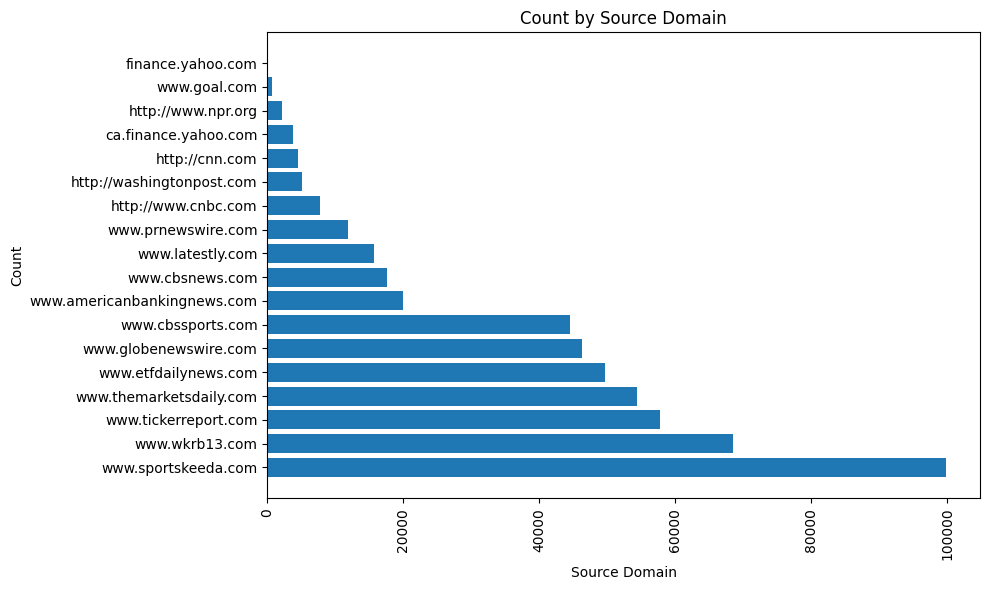

In [26]:
counts = data['source_domain'].value_counts()
plt.figure(figsize=(10, 6))
plt.barh(counts.index.astype(str), counts.values)
plt.xlabel('Source Domain')
plt.ylabel('Count')
plt.title("Count by Source Domain")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("size_sount.png", dpi=600)
plt.show()

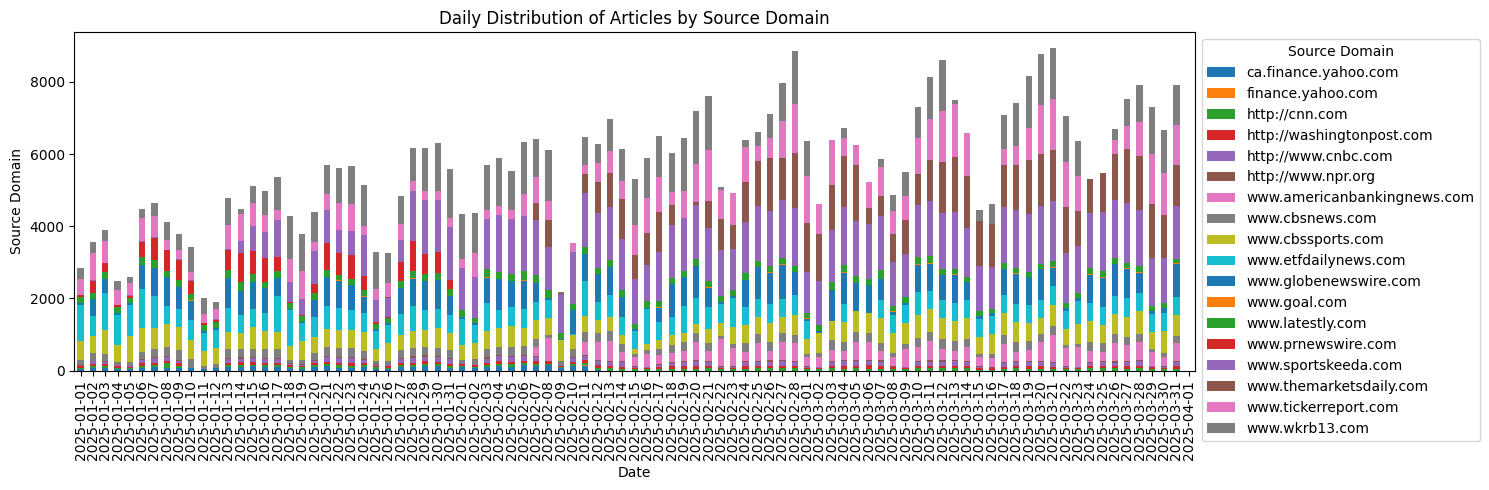

In [29]:
category_counts = data.groupby(['date', 'source_domain']).size().unstack(fill_value=0)

# Plot as a stacked bar chart
category_counts.plot(kind='bar', stacked=True, figsize=(15, 5))

plt.title("Daily Distribution of Articles by Source Domain")
plt.xlabel('Date')
plt.ylabel('Source Domain')
plt.xticks(rotation=90)
plt.legend(title='Source Domain', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig("daily_distribution.png", dpi=600)
plt.show()

## 4. Filter higher quality news

In [33]:
# examples
for domain in data['source_domain'].unique():
    print(domain)
    temp = data[data['source_domain'] == domain]
    for i in range(5):
        print('-', temp['title'].iloc[i])

http://cnn.com
- Jocelyn Wildenstein, ‘Catwoman’ socialite known for her extreme cosmetic surgery, dies
- Shamsud-Din Jabbar: What we know about the New Orleans attack suspect
- Tesla Cybertruck explosion at Trump hotel in Vegas investigated as a possible terrorist act, law enforcement official says
- Gypsy Rose Blanchard gives birth to her first baby
- MrBeast and Thea Booysen are engaged
http://www.cnbc.com
- Stock futures rise slightly to begin 2025 after S&P 500 notches back-to-back annual 20%-plus gains
- These restaurant chains closed locations in 2024
- The breakout stocks of 2024 that are not in the tech sector
- At least 10 killed in New Orleans truck attack, driver identified as U.S. citizen with ISIS flag
- Sugar Bowl postponed one day following deadly New Orleans attack
http://washingtonpost.com
- Live updates New Orleans attacker made videos indicating ISIS inspiration before killing 15, Biden says
- Attacker with ISIS flag drives truck into New Orleans crowd, killing 15
-

In [34]:
data_1 = data[[d[:7] == '2025-03' for d in data['date']]]
data_1.drop_duplicates(subset=['text'], keep='first', inplace=True)
print('March data before filtering:', len(data_1))
data_1 = data_1[data_1['source_domain'] != 'www.wkrb13.com']
data_1 = data_1[data_1['source_domain'] != 'www.etfdailynews.com']
data_1 = data_1[data_1['source_domain'] != 'www.americanbankingnews.com']
data_1 = data_1[data_1['source_domain'] != 'www.themarketsdaily.com']
data_1 = data_1[data_1['source_domain'] != 'www.tickerreport.com']
data_1 = data_1[data_1['source_domain'] != 'www.cbssports.com']
data_1 = data_1[data_1['source_domain'] != 'www.sportskeeda.com']
print('March data after filtering:', len(data_1))

/state/partition1/job-59643977/ipykernel_75857/3113399552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1.drop_duplicates(subset=['text'], keep='first', inplace=True)


March data before filtering: 207490
March data after filtering: 34817


In [35]:
data_sampled = (
    data_1
    .groupby('source_domain', group_keys=False)
    .apply(lambda grp: grp.sample(n=2000, replace=False) 
           if len(grp) >= 2000 else grp)
    .reset_index(drop=True)
)

/state/partition1/job-59643977/ipykernel_75857/2090826634.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(n=2000, replace=False)


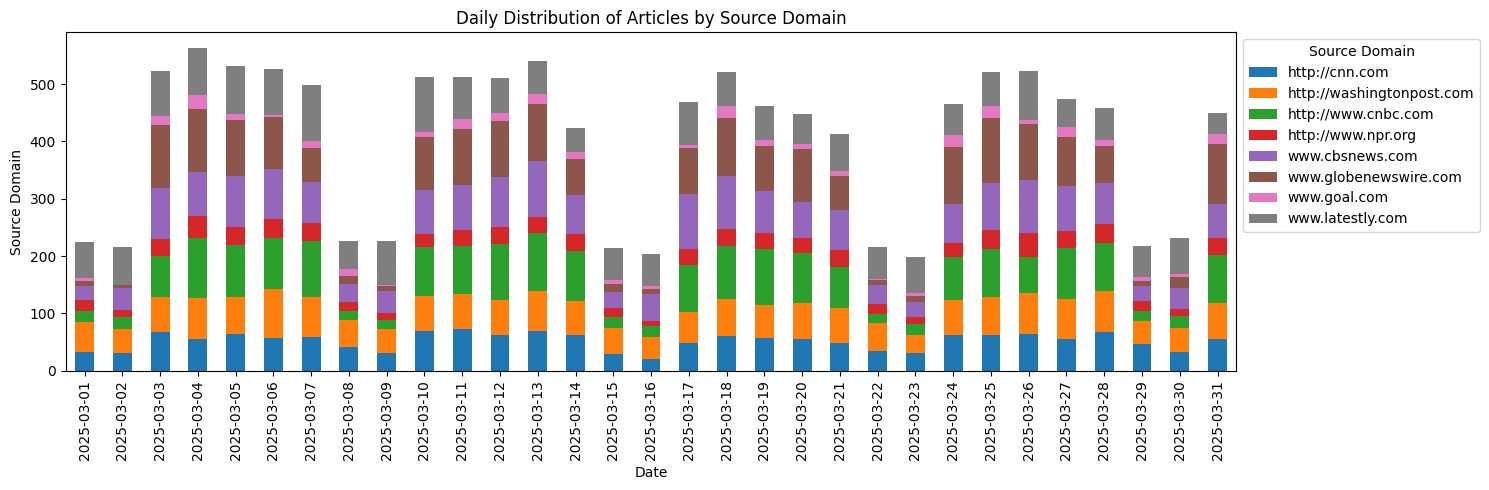

In [37]:
category_counts = data_sampled.groupby(['date', 'source_domain']).size().unstack(fill_value=0)

# Plot as a stacked bar chart
category_counts.plot(kind='bar', stacked=True, figsize=(15, 5))

plt.title("Daily Distribution of Articles by Source Domain")
plt.xlabel('Date')
plt.ylabel('Source Domain')
plt.xticks(rotation=90)
plt.legend(title='Source Domain', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig("daily_distribution_march.png", dpi=600)
plt.show()

In [38]:
def sample_up_to_k(grp):
    n = min(len(grp), 500)
    return grp.sample(n=n, replace=False, random_state=42)
    
data_final = (
    data_sampled
    .groupby('date', group_keys=False)
    .apply(sample_up_to_k)
    .reset_index(drop=True)
)

/state/partition1/job-59643977/ipykernel_75857/2725253550.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sample_up_to_k)


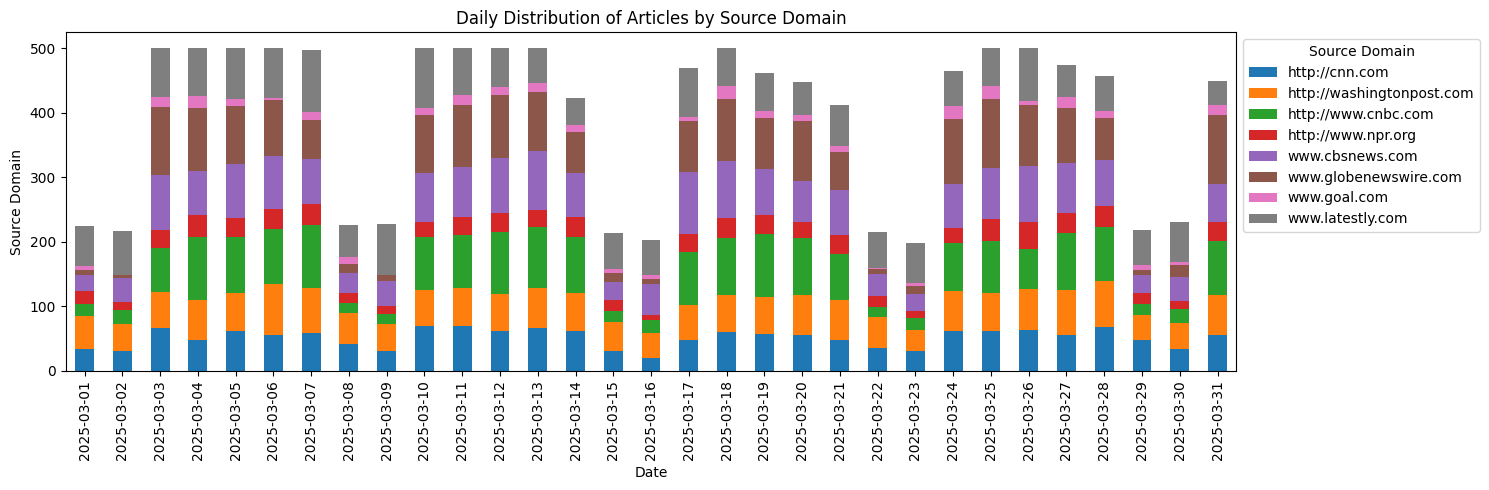

In [39]:
category_counts = data_final.groupby(['date', 'source_domain']).size().unstack(fill_value=0)

# Plot as a stacked bar chart
category_counts.plot(kind='bar', stacked=True, figsize=(15, 5))

plt.title("Daily Distribution of Articles by Source Domain")
plt.xlabel('Date')
plt.ylabel('Source Domain')
plt.xticks(rotation=90)
plt.legend(title='Source Domain', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig("daily_distribution_march.png", dpi=600)
plt.show()

In [40]:
len(data_sampled)

12513

In [104]:
data_sampled.to_csv("/scratch/hd2584/daily-news-clustering/news/news_2025_03_update.csv", index=False)